In [1]:
trainset = 'ePBRN_F_dup' 
testset = 'ePBRN_D_dup'

import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold

def generate_true_links(df): 
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:    
            processed = processed + 1
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]    
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    unique_match_id = unique_match_id[~np.isnan(unique_match_id)] # remove nan values
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

In [2]:
def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)

In [3]:
def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')  
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')  
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')      
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [4]:
def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

In [15]:
def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'svm': # Support Vector Machine
        model = svm.SVC(C = modelparam, kernel = modeltype_2)
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'lg': # Logistic Regression
        model = LogisticRegression(C=modelparam, penalty = modeltype_2, solver='saga')
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nb': # Naive Bayes
        model = GaussianNB()
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ), 
                              activation = modeltype_2,
                              learning_rate='constant',  learning_rate_init=0.001, max_iter=30000, shuffle=True)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result

def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)
    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)
    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)
    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)
    precision = count_true_pos/(count_true_pos+count_false_pos)
    sensitivity = count_true_pos/(count_true_pos+count_false_neg) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    Fscore = 2*precision*sensitivity/(precision+sensitivity)
    metrics_result = {'no_false':no_false, 'confusion_matrix':confusion_matrix ,'precision':precision,
                     'sensitivity':sensitivity ,'no_links':no_links_found, 'F-score': Fscore}
    return metrics_result

In [6]:
print("Import train set...")
df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
train_true_links = generate_true_links(df_train)
print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

df_train['postcode'] = df_train['postcode'].astype(str)

X_train, y_train = generate_train_X_y(df_train)
print("Finished building X_train, y_train")

Import train set...
Train set size: 14078 , number of matched pairs:  3192
Finished building X_train, y_train


In [7]:
print("Import test set...")
df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
    block_indexer = rl.BlockIndex(on=field)
    candidates = block_indexer.index(df_test)
    detects = blocking_performance(candidates, test_true_links, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )
detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...
Test set size: 11731 , number of matched pairs:  2653
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 252552 , detected  1567 /2653 true matched pairs, missed 1086
Number of pairs of matched surname: 33832 , detected  1480 /2653 true matched pairs, missed 1173
Number of pairs of matched postcode: 79940 , detected  2462 /2653 true matched pairs, missed 191
Number of pairs of at least 1 field matched: 362910 , detected  2599 /2653 true matched pairs, missed 54


In [8]:
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)

print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 360311, 1: 2599})
Finished building X_test, y_test


In [9]:
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
modeltype = 'svm' # choose between 'svm', 'lg', 'nn'
# modeltype_2 = 'rbf'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN

for modeltype_2 in ['linear', 'rbf']:
    print("Model:",modeltype,", Param_1:",modeltype_2, ", tuning range:", modelparam_range)
    precision = []
    sensitivity = []
    Fscore = []
    nb_false = []

    for modelparam in modelparam_range:
        md = train_model(modeltype, modelparam, X_train, y_train, modeltype_2)
        final_result = classify(md, X_test)
        final_eval = evaluation(y_test, final_result)
        precision += [final_eval['precision']]
        sensitivity += [final_eval['sensitivity']]
        Fscore += [final_eval['F-score']]
        nb_false  += [final_eval['no_false']]

    print("No_false:",nb_false,"\n")
    print("Precision:",precision,"\n")
    print("Sensitivity:",sensitivity,"\n")
    print("F-score:", Fscore,"\n")
    print("")

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: linear , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [1212, 1918, 54575, 77600, 77634, 77636, 77632, 77704, 78160, 78951, 80680, 80986, 82061, 82373, 84548, 84616, 83174, 83174, 83174, 83186] 

Precision: [0.6919457514530861, 0.5780426312170525, 0.04509172384820053, 0.032196898818656984, 0.03214824606252572, 0.03214744429064881, 0.032195718044315876, 0.03232997496793155, 0.03215899944275896, 0.0318585373031834, 0.03118583008105674, 0.031071655041217502, 0.030677093177093176, 0.030575497234317996, 0.029812381662746, 0.02978913694059372, 0.030289958144361147, 0.030289958144361147, 0.030289958144361147, 0.030285720947040788] 

Sensitivity: [0.9619084263178146, 0.9703732204694113, 0.9911504424778761, 0.9930742593305117, 0.9919199692189303, 0.9919199692189303, 0.9934590227010388, 0.9988457098884186, 0.9992304732589458, 0.9996152366294728, 0.99

In [16]:
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
modeltype = 'lg' # choose between 'svm', 'lg', 'nn'
# modeltype_2 = 'rbf'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN

for modeltype_2 in ['l1', 'l2']:
    print("Model:",modeltype,", Param_1:",modeltype_2, ", tuning range:", modelparam_range)
    precision = []
    sensitivity = []
    Fscore = []
    nb_false = []

    for modelparam in modelparam_range:
        md = train_model(modeltype, modelparam, X_train, y_train, modeltype_2)
        final_result = classify(md, X_test)
        final_eval = evaluation(y_test, final_result)
        precision += [final_eval['precision']]
        sensitivity += [final_eval['sensitivity']]
        Fscore += [final_eval['F-score']]
        nb_false  += [final_eval['no_false']]

    print("No_false:",nb_false,"\n")
    print("Precision:",precision,"\n")
    print("Sensitivity:",sensitivity,"\n")
    print("F-score:", Fscore,"\n")
    print("")

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: lg , Param_1: l1 , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]


/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No_false: [77615, 77615, 77505, 77505, 77505, 77517, 78294, 80058, 80984, 81872, 84530, 83850, 83898, 84119, 84138, 84133, 84174, 84185, 84128, 84178] 

Precision: [0.030798098573930448, 0.030798098573930448, 0.032141607954829364, 0.032141607954829364, 0.032141607954829364, 0.03224195199920082, 0.03194370586562125, 0.031409178352349035, 0.031072398569018535, 0.030745735020777345, 0.029818540750857943, 0.03005309611669578, 0.03003641829007457, 0.029959868997647493, 0.029953306047155126, 0.029955032860601867, 0.029940878865058602, 0.02993708372704017, 0.029956759873162295, 0.02993949870354365] 

Sensitivity: [0.9472874182377837, 0.9472874182377837, 0.9899961523662947, 0.9899961523662947, 0.9899961523662947, 0.9934590227010388, 0.993843786071566, 0.9988457098884186, 0.9992304732589458, 0.9992304732589458, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996

/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No_false: [1360, 1510, 1766, 2772, 7332, 29743, 52404, 70888, 79002, 79650, 81225, 82237, 82723, 83257, 83914, 84045, 84090, 84106, 84176, 84163] 

Precision: [0.6639322572109023, 0.6385143729330959, 0.5991902834008097, 0.4834513105031567, 0.258889454915945, 0.07950179700086751, 0.04682353369365435, 0.035164386358995305, 0.031815674980084564, 0.031576387622347865, 0.03098305893581484, 0.030624513756276964, 0.030450070323488045, 0.030260675099587672, 0.030030863127232375, 0.02998545739941368, 0.029969891679259866, 0.029964361094771807, 0.0299401887683957, 0.029944674965421855] 

Sensitivity: [0.9653712966525587, 0.9657560600230858, 0.9680646402462486, 0.972297037322047, 0.9776837245094268, 0.9873028087726049, 0.9899961523662947, 0.993843786071566, 0.9988457098884186, 0.9992304732589458, 0.9992304732589458, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728] 

F

/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [17]:
print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
modeltype = 'nn' # choose between 'svm', 'lg', 'nn'
# modeltype_2 = 'rbf'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN

for modeltype_2 in ['relu', 'logistic']:
    print("Model:",modeltype,", Param_1:",modeltype_2, ", tuning range:", modelparam_range)
    precision = []
    sensitivity = []
    Fscore = []
    nb_false = []

    for modelparam in modelparam_range:
        md = train_model(modeltype, modelparam, X_train, y_train, modeltype_2)
        final_result = classify(md, X_test)
        final_eval = evaluation(y_test, final_result)
        precision += [final_eval['precision']]
        sensitivity += [final_eval['sensitivity']]
        Fscore += [final_eval['F-score']]
        nb_false  += [final_eval['no_false']]

    print("No_false:",nb_false,"\n")
    print("Precision:",precision,"\n")
    print("Sensitivity:",sensitivity,"\n")
    print("F-score:", Fscore,"\n")
    print("")

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: nn , Param_1: relu , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
No_false: [84792, 89191, 80174, 84491, 82557, 85451, 85783, 84414, 84190, 81650, 80330, 79599, 78766, 58085, 27259, 6272, 1745, 1428, 1185, 360311] 

Precision: [0.029686087364530045, 0.028294075349181793, 0.031365157611125204, 0.02981029810298103, 0.030487375220199647, 0.029506632745775033, 0.029395790902919213, 0.02985829377894749, 0.029935358982336065, 0.03082675529705027, 0.031317455532107324, 0.0315959802418668, 0.031804379095413136, 0.042526878174262914, 0.08607492950181281, 0.29018622186678855, 0.6024963994239079, 0.6521174330995063, 0.6964980544747081, 0.007161555206525034] 

Sensitivity: [0.9980761831473643, 0.9992304732589458, 0.9988457098884186, 0.9988457098884186, 0.9988457098884186, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9992304732589458, 0.999

/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


No_false: [83479, 85521, 84883, 84807, 82067, 82844, 81447, 84622, 81604, 80880, 78689, 70034, 35337, 6348, 2005, 1530, 1183, 2599, 2599, 360311] 

Precision: [0.03019354538906573, 0.029493871992737175, 0.02969821673525377, 0.029724040089698412, 0.030686005858452235, 0.030406947484228883, 0.030901216058637347, 0.029787087675850445, 0.03084359671730068, 0.03111111111111111, 0.03183451466824178, 0.035578022341290066, 0.06784941126775437, 0.2876882999207158, 0.5668316831683168, 0.6352822070361933, 0.6968854282536151, nan, nan, 0.007161555206525034] 

Sensitivity: [1.0, 1.0, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9996152366294728, 0.9992304732589458, 0.9996152366294728, 0.9992304732589458, 0.9992304732589458, 0.9953828395536745, 0.993843786071566, 0.9888418622547134, 0.9772989611388996, 0.9692189303578299, 0.9657560600230858, 0.9642170065409773, 0.0, 0.0, 1.0] 

F-score: [0.05861722881919775, 0.057297809720124784, 0.05768270074046115, 0.057731408953034906, 0.05954413

/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/lanj3/anaconda3/envs/cuda_envs/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


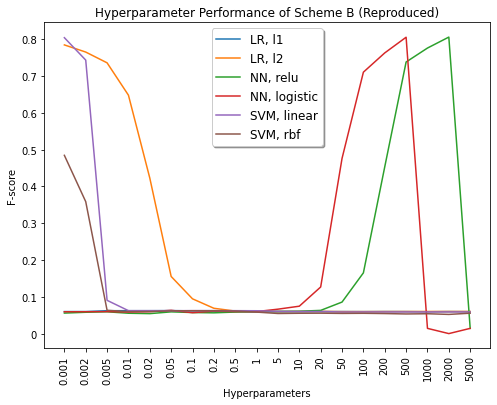

In [22]:
import pylab as plt


fig, ax = plt.subplots(figsize=(8, 6))
ax.locator_params(axis='x', nbins=22)
ax.locator_params(axis='y', nbins=12)
# lg, l1
plt.plot([0.059870099744838784, 0.059870099744838784, 0.06226179961524966, 0.06226179961524966, 0.06226179961524966, 0.06245993444367842, 0.06183938040915023, 0.06064447966191232, 0.059972991378016836, 0.05948687419144332, 0.05919613561793656, 0.05940367758819697, 0.05976086456656703, 0.05992621627853354, 0.059749873557404944, 0.05996423833419854, 0.05984756027356253, 0.05939621089197158, 0.059873755989679325, 0.059651820654356834]  ,label='LR, l1' )
# lg, l2
plt.plot([0.7847982483578355, 0.7653605732581187, 0.7360725252229858, 0.6481149012567325, 0.4227696404793609, 0.15530394768709133, 0.0945168464974358, 0.06884236617315867, 0.061224971109171945, 0.06081753568375818, 0.05982905982905983, 0.06023844869177955, 0.06034572831651904, 0.05973682698385335, 0.059776671228308244, 0.059902045520023046, 0.06000230866905229, 0.060085539244018035, 0.060073039940828396, 0.060131414557401314] ,label='LR, l2'  )
# nn, relu
plt.plot([0.05574875493731753, 0.057995935594810075, 0.05930799721279829, 0.05533714748404555, 0.05429873714142344, 0.05913213688247544, 0.05725813563806332, 0.05649275078583005, 0.058574198493935165, 0.05968503394327854, 0.06039675341287007, 0.060856727749917974, 0.06309502041811421, 0.08571856237630349, 0.16512047416570028, 0.4533523792518525, 0.7383122610996765, 0.7762486469769599, 0.8060469604374397, 0.014221264045481782] ,label = 'NN, relu' )
# nn, logistic
plt.plot([0.059354160957339905, 0.05947938368552394, 0.05983171610437746, 0.058541310027930435, 0.0596374483708123, 0.06330378020265004, 0.05681371048834871, 0.06117957228440614, 0.0598900402263742, 0.05987181851715234, 0.06641300588031823, 0.07449616988127353, 0.12671334187949904, 0.4761904761904762, 0.7106785160107209, 0.7630338957288342, 0.8056582542999517, 0.014221264045481782, 0, 0.014221264045481782] , label = 'NN, logistic' )
# svm, linear
plt.plot([0.8044422984065669, 0.7435064935064934, 0.09041572264081356, 0.06236483792632684, 0.06234826615776695, 0.06227654845878829, 0.06237016280979758, 0.06253688736856053, 0.062323014158867276, 0.06212918660287081, 0.060586980095847766, 0.06014863519551779, 0.06013731778763213, 0.0587662925416365, 0.05898653099234561, 0.05898519124193695, 0.05898921067575241, 0.05898720089037285, 0.059013338787011156, 0.05901199781857844] ,label = 'SVM, linear' )
# svm, rbf
plt.plot([0.4846306630095527, 0.3586888440392511, 0.0632763407862049, 0.059837623078251856, 0.059998614350707836, 0.06189398451459202, 0.0622491643804435, 0.06209814279226522, 0.06139345908086976, 0.058460327278861836, 0.05466170315687635, 0.055298362121260505, 0.05552112495458722, 0.05488274857197158, 0.05520566713043109, 0.054498941055589334, 0.05339332121249474, 0.05402090997900688, 0.0521555834378921, 0.05548078360998954] ,label = 'SVM, rbf' )
plt.xlabel('Hyperparameters')
plt.ylabel('F-score')
plt.title('Hyperparameter Performance of Scheme B (Reproduced)')
#fig.canvas.draw()

xlabels = ['',0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
ax.set_xticklabels(xlabels,rotation='vertical')
ylabels = ['',0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1.0]
ax.set_yticklabels(ylabels)

legend = ax.legend(loc='upper center', shadow=True,fontsize='large')
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('#00FFCC')

plt.show()
fig.savefig('schemeB_1.png', bbox_inches='tight')

In [23]:
## ENSEMBLE CLASSIFICATION AND EVALUATION

print("BAGGING PERFORMANCE:\n")
modeltypes = ['svm', 'nn', 'lg'] 
modeltypes_2 = ['linear', 'relu', 'l2']
modelparams = [0.001, 2000, 0.001]
nFold = 10
kf = KFold(n_splits=nFold)
model_raw_score = [0]*3
model_binary_score = [0]*3
model_i = 0
for model_i in range(3):
    modeltype = modeltypes[model_i]
    modeltype_2 = modeltypes_2[model_i]
    modelparam = modelparams[model_i]
    print(modeltype, "per fold:")
    iFold = 0
    result_fold = [0]*nFold
    final_eval_fold = [0]*nFold
    for train_index, valid_index in kf.split(X_train):
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        md =  train_model(modeltype, modelparam, X_train_fold, y_train_fold, modeltype_2)
        result_fold[iFold] = classify(md, X_test)
        final_eval_fold[iFold] = evaluation(y_test, result_fold[iFold])
        print("Fold", str(iFold), final_eval_fold[iFold])
        iFold = iFold + 1
    bagging_raw_score = np.average(result_fold, axis=0)
    bagging_binary_score  = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > 0.5] = 1
    bagging_binary_score[bagging_binary_score <= 0.5] = 0
    bagging_eval = evaluation(y_test, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print('')
    model_raw_score[model_i] = bagging_raw_score
    model_binary_score[model_i] = bagging_binary_score
    
thres = .99
print("STACKING PERFORMANCE:\n")
stack_raw_score = np.average(model_raw_score, axis=0)
stack_binary_score = np.copy(stack_raw_score)
stack_binary_score[stack_binary_score > thres] = 1
stack_binary_score[stack_binary_score <= thres] = 0
stacking_eval = evaluation(y_test, stack_binary_score)
print(stacking_eval)

BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 1 {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 2 {'no_false': 1210, 'confusion_matrix': [2497, 1108, 102, 359203], 'precision': 0.6926490984743412, 'sensitivity': 0.9607541362062332, 'no_links': 3605, 'F-score': 0.8049645390070921}
Fold 3 {'no_false': 1208, 'confusion_matrix': [2498, 1107, 101, 359204], 'precision': 0.6929264909847435, 'sensitivity': 0.9611388995767602, 'no_links': 3605, 'F-score': 0.8052869116698904}
Fold 4 {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 5 {'no_false